<a href="https://colab.research.google.com/github/tdegamboda/visual_semantic_reasoning/blob/master/RGB_Data_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating the Custom Dataset

Import necessary libraries

In [1]:
import sys
import time
import os
import math
import copy
import string
import re
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from torch.autograd import Variable

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, GlobalMaxPool2D, Conv2D, MaxPooling2D, Flatten, GlobalMaxPool1D, Dense, Embedding, GRU, \
    Bidirectional, Concatenate, Lambda, SpatialDropout1D, Reshape, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print(tf.__version__)

2.3.0


Mount Google Drive account

In [3]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import zipfile

file_path = "gdrive/My Drive/fashion_data.zip"

archive = zipfile.ZipFile(file_path, 'r')
archive.extractall()

Obtain the csv file from the zip which contains all the attributes of each image based on the id

In [5]:
styles = pd.read_csv('styles.csv', names = ['id',
 'gender',
 'masterCategory',
 'subCategory',
 'articleType',
 'baseColour',
 'season',
 'year',
 'usage',
 'productDisplayName'])

styles = styles[1:]

In [6]:
#Make a list of all the ids in the csv file
ids = list(styles['id'])

In [7]:
import cv2
import os
from PIL import Image

def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        img = np.array(img)
        if img is not None:
            images[filename] = img
    return images

In [8]:
#Load all the images into a file
#Note however the iamges are not in order with respect to the csv
image_files = 'images'
images = load_images_from_folder(image_files)

In [9]:
#Refine the csv to only the ids which exist in the image folder and reorder the images to the order of the csv
ordered_imgs = []
for id in ids:
    if id in [i[:-4] for i in list(images.keys())]:
        ordered_imgs.append(images[id + ".jpg"])
    else:
        styles = styles[styles['id'] != id]

Create a set of descriptions for each image based on the csv given

In [10]:
styles

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
1,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
2,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
3,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
4,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
5,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44442,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013,Casual,Gas Men Caddy Casual Shoe
44443,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011,Casual,Lotto Men's Soccer Track Flip Flop
44444,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Puma Men Graphic Stellar Blue Tshirt
44445,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Rasasi Women Blue Lady Perfume


In [11]:
styles.loc[styles['masterCategory'] == "dress"]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName


In [12]:
#We only take specific attributes from the df in order to create our custom descriptions
target_labels = styles.iloc[:, [1, 2, 3, 8, 5, 4]].values

In [13]:
captions = []
caption_labels = []
for i in range(len(target_labels)):
    description = ""
    label_list = []
    for j in target_labels[i]:
        if type(j) == str:
            description = description + j + " "
            label_list.append(j)
        else:
            continue
    captions.append(description[:-1])
    caption_labels.append(label_list)

From further investigation it is clear that there are a series of images that are not RGB images. These images will be removed from the dataset for convenince

In [14]:
count = 0
bad_imgs_idx = []
for idx, i in enumerate(ordered_imgs):
    if np.shape(i) != (80, 60, 3):
        bad_imgs_idx.append(idx)
        count += 1
print(count)
ordered_imgs = np.array([ordered_imgs[i] for i in range(len(ordered_imgs)) if i not in bad_imgs_idx])
captions = [captions[i] for i in range(len(captions)) if i not in bad_imgs_idx]
caption_labels = [caption_labels[i] for i in range(len(caption_labels)) if i not in bad_imgs_idx]

454


We note that 453 images have now been cleared from the original dataset

In [15]:
assert len(ordered_imgs) == len(captions)
np.shape(ordered_imgs)

(43987, 80, 60, 3)

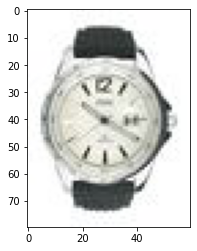

In [16]:
plt.imshow(ordered_imgs[41])

In [17]:
np.shape(ordered_imgs[0])

(80, 60, 3)

In [18]:
captions[41]

'Men Accessories Watches Casual Off White Watches'

In [19]:
captions[86]

'Unisex Accessories Bags Casual Orange Laptop Bag'

In [20]:
caption_labels[41]

['Men', 'Accessories', 'Watches', 'Casual', 'Off White', 'Watches']

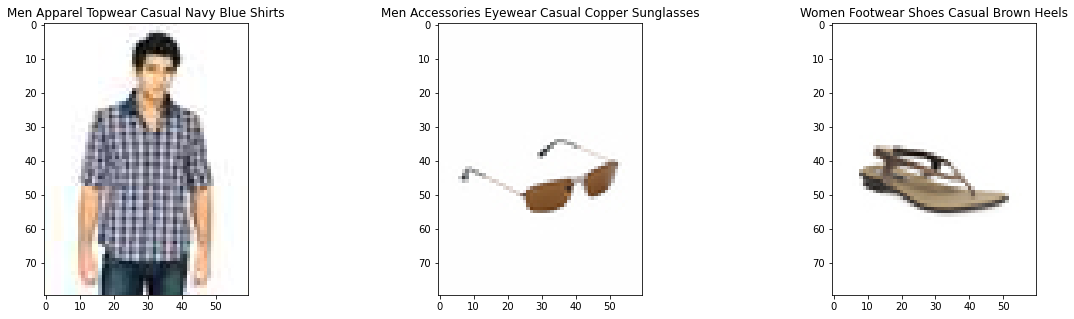

In [21]:
idx_list = [0, 123, 3243]
image_examples = ordered_imgs[idx_list]

figs, axs = plt.subplots(1, 3, figsize = (20, 5))

for idx, img_path in enumerate(image_examples):
    axs[idx].imshow(img_path)
    axs[idx].set_title(captions[idx_list[idx]])

plt.savefig('RGB_data_example.png', dpi = 1000)

# Preprocessing the Data

We are going to import the genism model in order to implement the pretrained word2vec embeddings

In [22]:
# https://stackoverflow.com/questions/55444572/how-does-i-unzip-pretrained-word2vec-in-google-colab
start_time = time.time()
!wget -P /tmp/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
elapsed_time = time.time() - start_time
print('Downloading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

--2020-09-25 06:09:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.69.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.69.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/tmp/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  36.4MB/s    in 44s     

2020-09-25 06:10:03 (35.8 MB/s) - ‘/tmp/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [23]:
# Load Google's pre-trained Word2Vec model.
start_time = time.time()
word2Vec_filePath = '/tmp/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(word2Vec_filePath, binary=True)
!rm -f word2Vec_filePath
elapsed_time = time.time() - start_time
print('Loading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loading the pre-trained Word2Vec model took 117 seconds


We will now clean the text descriptions so that they are in appropriate format for our model

In [24]:
#Create list of all punctuation in the text
punctuation = []
for p in string.punctuation:
    punctuation.append(p)
punctuation.append("''")
punctuation.append("--")
punctuation.append("##")
punctuation.append("``")

In [25]:
def remove_punctuation(descriptions):
    new_sentences = []
    for sentence in descriptions:
        words = sentence.split()
        no_punc_words = [words[i].lower() for i in range(len(words)) if words[i] not in punctuation]
        new_sentences.append(" ".join(no_punc_words))
    return new_sentences

In [26]:
clean_captions = remove_punctuation(captions)

In [27]:
from collections import Counter

all_text = ' '.join(clean_captions)
words = all_text.split()

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [28]:
vocab_to_int = {w:i for i,(w,c) in enumerate(sorted_words, 1)}
int_to_vocab = {i:w for i,(w,c) in enumerate(sorted_words, 1)}

vocab_size = len(vocab_to_int)

In [29]:
vocab_size

249

In order to handle unseen words we must include another token which handles these words

In [30]:
vocab_to_int['UNK'] = vocab_size + 1
int_to_vocab[vocab_size + 1] = 'UNK'

vocab_size  = len(vocab_to_int)

In [31]:
vocab_size

250

In [32]:
# create array of train embeddings vectors to be fed into torch
emb_weights = np.random.rand(vocab_size + 1, 300)

for key, val in int_to_vocab.items():
    if val in model.vocab:
        emb = model.get_vector(val)
        emb_weights[key] = emb

In [33]:
#Delete the full Word2Vec model to free up disk space
del model

In [34]:
def tokenizer(descriptions):
    sentence_tokens = []
    for sentence in descriptions:
        sent_tokens = []
        for word in sentence.split():
            sent_tokens.append(vocab_to_int.get(word, vocab_to_int["UNK"]))
        sentence_tokens.append(sent_tokens)
    return sentence_tokens

In [35]:
caption_tokens = tokenizer(clean_captions)

In order to regulate the sentence length we will pad each description

In [36]:
def padded_tokens(sentences, seq_len):
    #If sentence length is shorter than the seq_len we will pad the sentence with 0 and if the sentence is longer than the seq_len we will truncate the sentence
    padded_features = np.zeros((len(sentences), seq_len), dtype = int)
    for i, sentence in enumerate(sentences):
        if len(sentence) <= seq_len:
            padding = list(np.zeros(seq_len - len(sentence)))
            new = padding + sentence
        else:
            new = sentence[:seq_len]
        padded_features[i, :] = new
        
    return padded_features

Let us analyse the sequence lengths in order to set a fixed length for all the captions

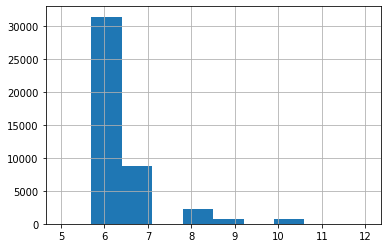

count    43987.000000
mean         6.416896
std          0.799573
min          5.000000
25%          6.000000
50%          6.000000
75%          7.000000
max         12.000000
dtype: float64

In [37]:
sentence_len = [len(x) for x in caption_tokens]
pd.Series(sentence_len).hist()
plt.show()
pd.Series(sentence_len).describe()

As the maximum length of any caption is 12 tokens we will set the length of all the captions to be 12. This is assuming that having a sentence representation of 12 vectors does not 

In [65]:
MAX_SEQ_LEN = 12
pad_tokens = padded_tokens(caption_tokens, MAX_SEQ_LEN)

# Model Implementation

Now we will start to construct the model. This model's purpose is to map the image representation and the description semantic representation to the same vector space. We attempt to minimise the distance between the image and the positive label along with maximising the distance between the image and the negative label. To do this we will use triplet loss

In [66]:
def triplet_loss(y_true, y_pred, alpha=0.9):
    """
    https://github.com/KinWaiCheuk/Triplet-net-keras/blob/master/Triplet%20NN%20Test%20on%20MNIST.ipynb
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    total_length = y_pred.shape.as_list()[-1]
    anchor = y_pred[:, 0:int(total_length * 1 / 3)]
    positive = y_pred[:, int(total_length * 1 / 3):int(total_length * 2 / 3)]
    negative = y_pred[:, int(total_length * 2 / 3):int(total_length * 3 / 3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor - positive), axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # compute loss
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)

    return loss


In [67]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from random import choice, sample

vec_dim = 100

def gen(list_images, list_captions, batch_size=16):
    indexes = list(range(len(list_images)))
    while True:
        batch_indexes = sample(indexes, batch_size)

        candidate_images = [list_images[i] for i in batch_indexes]
        captions_p = [list_captions[i] for i in batch_indexes]

        captions_n = [choice(list_captions) for _ in batch_indexes]

        X1 = np.array([preprocess_input(x) for x in candidate_images])
        X2 = np.array(captions_p)
        X3 = np.array(captions_n)

        yield [X1, X2, X3], np.zeros((batch_size, 3 * vec_dim))

In [68]:
next(gen(ordered_imgs, pad_tokens))

([array([[[[151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           ...,
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ]],
  
          [[151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           ...,
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ]],
  
          [[151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           ...,
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ],
           [151.061  , 138.22101, 131.32   ]],
  
          ...,
  
          [[151.061  , 137.22101, 131.32   ],
           [151.061  , 137.22101, 131.32   ],
  

In [69]:
def model(vocab_size, lr=0.0001):
    input_1 = Input(shape=(None, None, 3))
    input_2 = Input(shape=(None,))
    input_3 = Input(shape=(None,))

    base_model = ResNet50(weights='imagenet', include_top=False)

    x1 = base_model(input_1)
    x1 = GlobalMaxPool2D()(x1)

    dense_1 = Dense(vec_dim, activation="linear", name="dense_image_1")

    x1 = dense_1(x1)

    embed = Embedding(vocab_size + 1, 300, weights=[emb_weights],  name="word2vec_embed", trainable = False)

    gru = Bidirectional(GRU(256, return_sequences=True), name="gru_1")
    dense_2 = Dense(vec_dim, activation="linear", name="dense_text_1")

    x2 = embed(input_2)
    x2 = gru(x2)
    x2 = GlobalMaxPool1D()(x2)
    x2 = dense_2(x2)

    x3 = embed(input_3)
    x3 = gru(x3)
    x3 = GlobalMaxPool1D()(x3)
    x3 = dense_2(x3)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)
    x2 = _norm(x2)
    x3 = _norm(x3)

    x = Concatenate(axis=-1)([x1, x2, x3])

    model = Model([input_1, input_2, input_3], x)

    model.compile(loss=triplet_loss, optimizer=Adam(lr))

    model.summary()

    return model

In [70]:
model = model(vocab_size = vocab_size, lr=0.00001)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
word2vec_embed (Embedding)      (None, None, 300)    75300       input_9[0][0]                    
                                                                 input_10[0][0]        

In [71]:
#Split the data into train and val
from sklearn.model_selection import train_test_split

idx_list = list(range(len(ordered_imgs)))
train_idx, test_val_idx = train_test_split(idx_list, test_size = 0.4, shuffle = True, random_state = 2020)
train_imgs, train_p_captions = ordered_imgs[train_idx], pad_tokens[train_idx]

val_idx, test_idx = train_test_split(test_val_idx, test_size = 0.5, shuffle = True, random_state = 2020)

val_imgs, val_p_captions = ordered_imgs[val_idx], pad_tokens[val_idx]
test_imgs, test_p_captions = ordered_imgs[test_idx], pad_tokens[test_idx]

In [72]:
file_path = "model_triplet_5.h5"
BATCH_SIZE = 32

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_ = ReduceLROnPlateau(monitor="val_loss", mode='min', patience=5, min_lr=1e-7)

model.fit(gen(train_imgs, train_p_captions, batch_size=BATCH_SIZE),
                    use_multiprocessing=True,
                    validation_data=gen(val_imgs, val_p_captions, batch_size=BATCH_SIZE), epochs=300,
                    verbose=1, workers=-1, steps_per_epoch=np.ceil(len(train_imgs)/BATCH_SIZE), validation_steps=np.ceil(len(val_imgs)/BATCH_SIZE), callbacks=[es, checkpoint, reduce_])
model.save_weights(file_path)

Epoch 1/300
825/825 [==============================] - ETA: 0s - loss: 0.3167
Epoch 00001: val_loss improved from inf to 0.15490, saving model to model_triplet_5.h5
825/825 [==============================] - 166s 201ms/step - loss: 0.3167 - val_loss: 0.1549
Epoch 2/300
825/825 [==============================] - ETA: 0s - loss: 0.1231
Epoch 00002: val_loss improved from 0.15490 to 0.10453, saving model to model_triplet_5.h5
825/825 [==============================] - 163s 198ms/step - loss: 0.1231 - val_loss: 0.1045
Epoch 3/300
825/825 [==============================] - ETA: 0s - loss: 0.0874
Epoch 00003: val_loss improved from 0.10453 to 0.07738, saving model to model_triplet_5.h5
825/825 [==============================] - 163s 198ms/step - loss: 0.0874 - val_loss: 0.0774
Epoch 4/300
825/825 [==============================] - ETA: 0s - loss: 0.0716
Epoch 00004: val_loss improved from 0.07738 to 0.07022, saving model to model_triplet_5.h5
825/825 [==============================] - 163s 1

# Query Section

Now we will use our test images in order to create an image query model. First we establish seperate models to encode the images and text. 

In [73]:
def image_model(lr=0.0001):
    input_1 = Input(shape=(None, None, 3))

    base_model = ResNet50(weights='imagenet', include_top=False)

    x1 = base_model(input_1)
    x1 = GlobalMaxPool2D()(x1)

    dense_1 = Dense(vec_dim, activation="linear", name="dense_image_1")

    x1 = dense_1(x1)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)

    model = Model([input_1], x1)

    model.compile(loss="mae", optimizer=Adam(lr))

    model.summary()

    return model

def text_model(vocab_size, lr=0.0001):
    input_2 = Input(shape=(None,))

    embed = Embedding(vocab_size + 1, 300,  name="word2vec_embed", trainable = False)
    gru = Bidirectional(GRU(256, return_sequences=True), name="gru_1")
    dense_2 = Dense(vec_dim, activation="linear", name="dense_text_1")

    x2 = embed(input_2)
    x2 = gru(x2)
    x2 = GlobalMaxPool1D()(x2)
    x2 = dense_2(x2)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x2 = _norm(x2)

    model = Model([input_2], x2)

    model.compile(loss="mae", optimizer=Adam(lr))

    model.summary()

    return model

In [74]:
t_model = text_model(vocab_size = vocab_size)
i_model = image_model()

t_model.load_weights(file_path, by_name=True)
i_model.load_weights(file_path, by_name=True)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
word2vec_embed (Embedding)   (None, None, 300)         75300     
_________________________________________________________________
gru_1 (Bidirectional)        (None, None, 512)         857088    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_text_1 (Dense)         (None, 100)               51300     
_________________________________________________________________
lambda_4 (Lambda)            (None, 100)               0         
Total params: 983,688
Trainable params: 908,388
Non-trainable params: 75,300
___________________________________________

First we will encode the images

In [75]:
def chunker(seq, size):
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]

In [76]:
from tqdm import tqdm


target_image_encoding = []

for img in tqdm(chunker(test_imgs, 128), total=len(test_imgs)//128):
    image_vecs = np.asarray([preprocess_input(img[i]) for i in range(len(img))])
    e = i_model.predict(image_vecs)
    target_image_encoding += e.tolist()

69it [00:16,  4.30it/s]


In [77]:
query_text = ["women footwear formal shoes", "men navy blue tshirts", "women watches", "men watches", "top"]

cleaned_text = remove_punctuation(query_text)
query_tokens = tokenizer(cleaned_text)
pad_query_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

target_text_encoding = t_model.predict(np.asarray(pad_query_tokens), verbose = 2)

1/1 - 0s


In [78]:
np.shape(target_text_encoding)

(5, 100)

In [79]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_jobs=-1, n_neighbors=9)
nn.fit(target_image_encoding)

distances, preds = nn.kneighbors(target_text_encoding, return_distance=True)

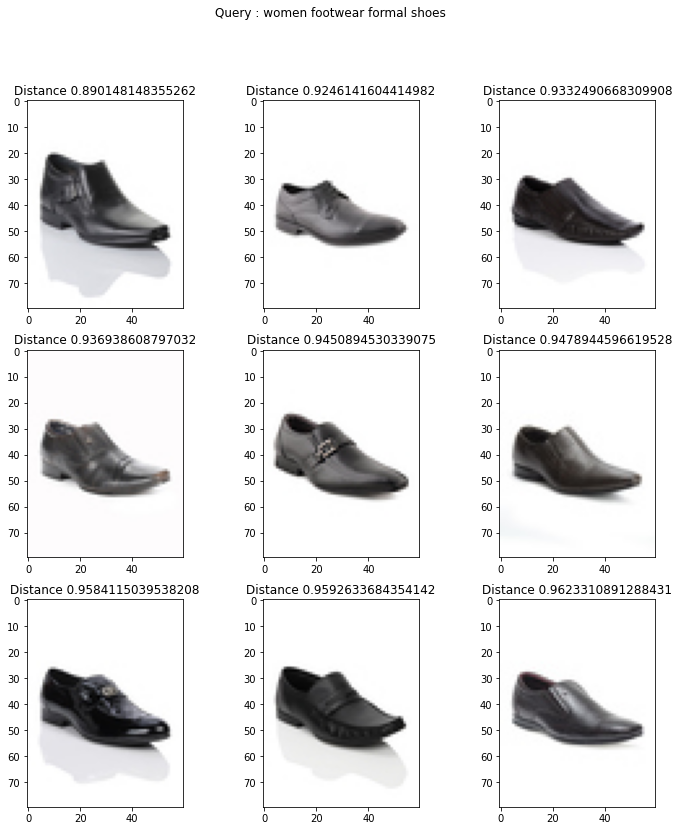

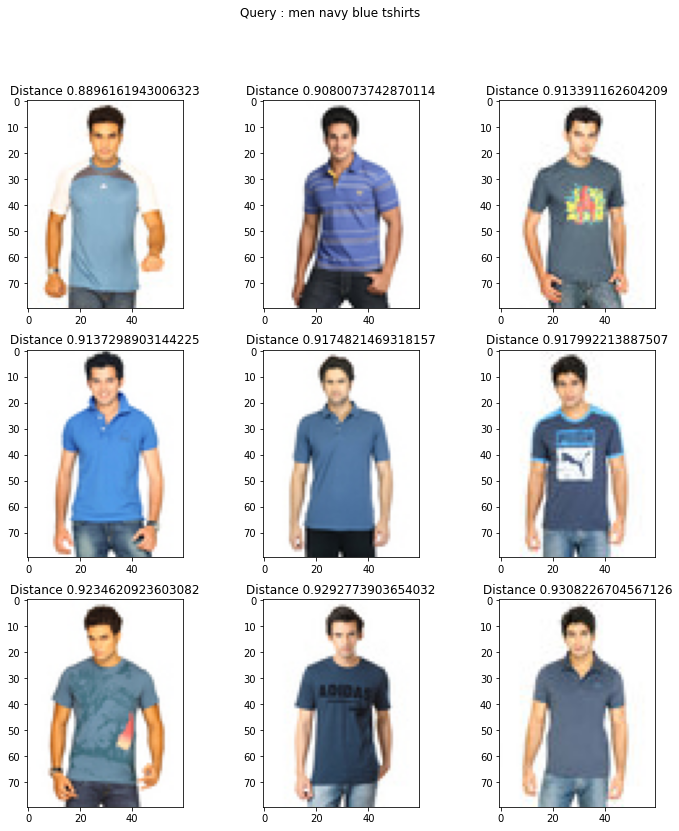

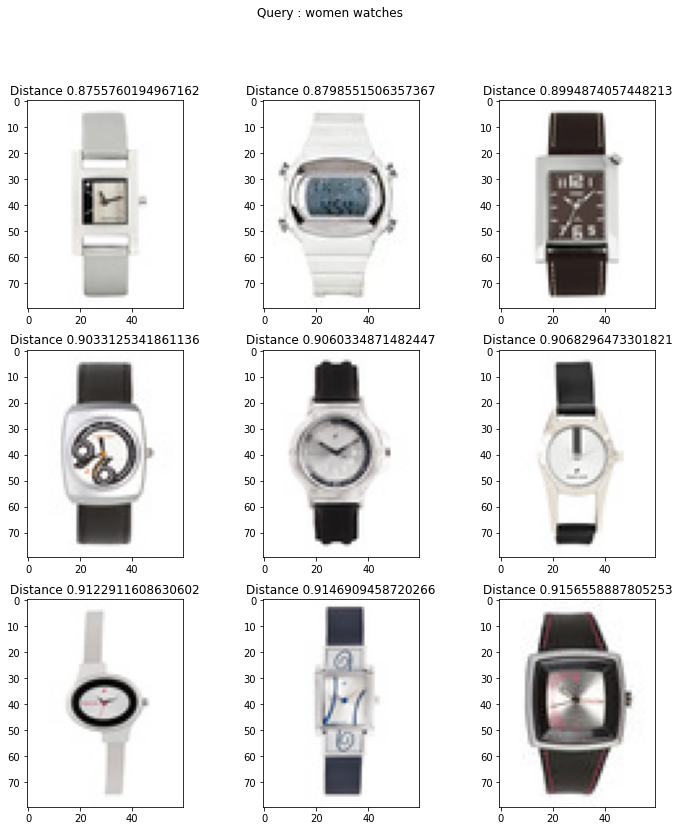

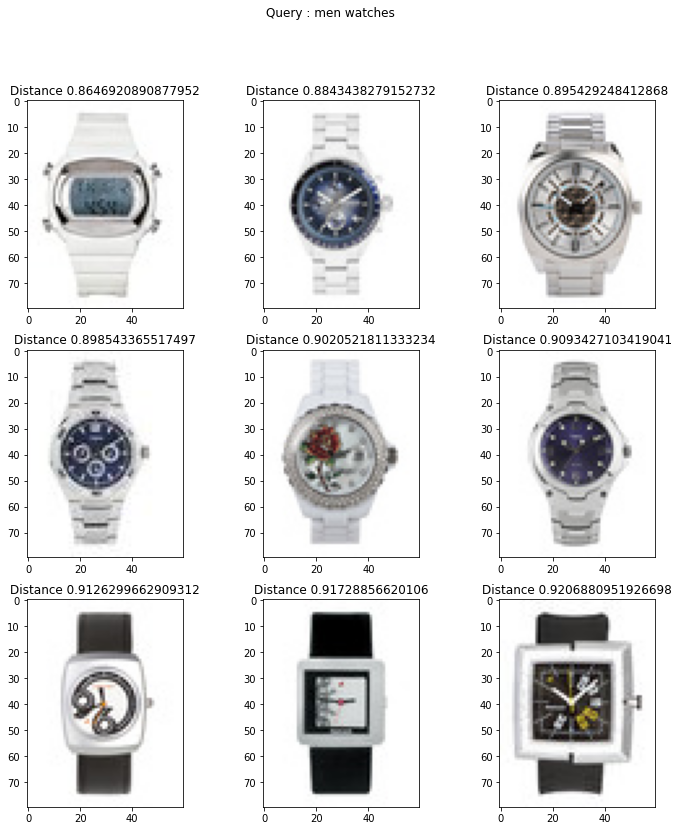

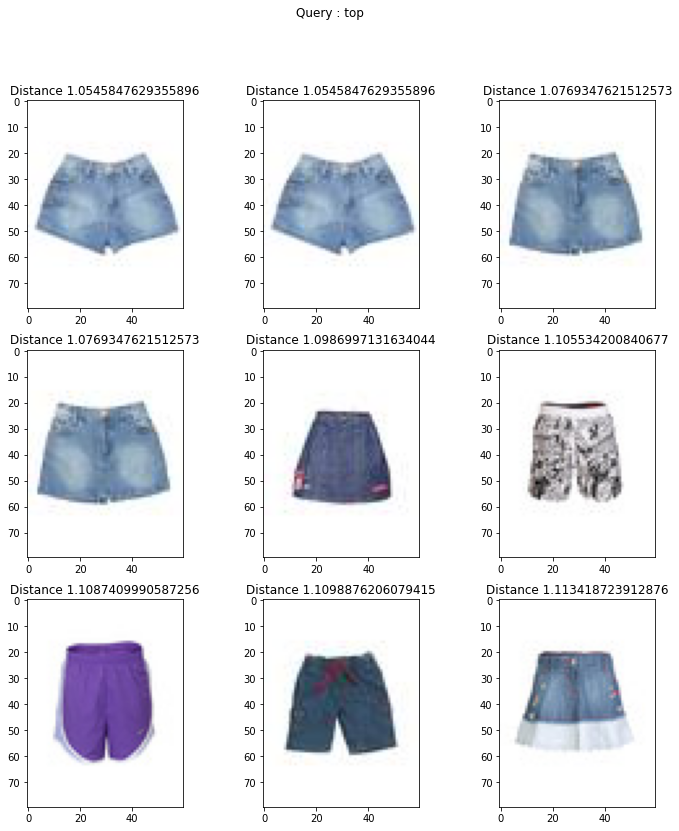

In [80]:
most_similar_images = []
query_image = []
count = 0


for i in range(len(preds)):
    pred_imgs = test_imgs[preds[i].tolist()]
    most_similar_images.append(pred_imgs)

for q, all_images in zip(query_text, most_similar_images):
    fig, axes = plt.subplots(3, 3, figsize = (12, 13))

    for idx, img_path in enumerate(all_images):
        i = idx // 3  # Get subplot row
        j = idx % 3  # Get subplot column
        axes[i, j].imshow(img_path, cmap = 'gray')
        axes[i, j].set_title('Distance {}'.format(distances[count, idx]))

    count += 1
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    fig.suptitle('Query : %s'%q)
    plt.savefig("{}_results".format(q))

In [55]:
for x in preds[1]:
    print(captions[test_idx[x]])

Men Apparel Topwear Sports Blue Tshirts
Men Apparel Topwear Casual Navy Blue Tshirts
Men Apparel Topwear Casual Blue Tshirts
Men Apparel Topwear Sports Navy Blue Tshirts
Men Apparel Topwear Casual Blue Tshirts
Men Apparel Topwear Casual Blue Tshirts
Men Apparel Topwear Casual Blue Tshirts
Men Apparel Topwear Casual Blue Tshirts
Men Apparel Topwear Casual Blue Tshirts


Now we will try a reverse search i.e. allowing the NN model to train on text representations and query the model using images

In [ ]:
text_space = [captions[test_idx[0]], captions[test_idx[789]], captions[test_idx[7]], "women", "black", "shirt", "casual", "women black casual shirt",
              "men", "navy", "blue", "tshirt", "men casual blue tshirt", "men casual shorts",
              "brown", "bag", "women brown bag"]

cleaned_text = remove_punctuation(text_space)
query_tokens = tokenizer(cleaned_text)
pad_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

text_encodings = t_model.predict(np.asarray(pad_tokens), verbose = 2)

1/1 - 0s


In [ ]:
target_image_encoding = []

query_images = [test_imgs[0], test_imgs[789], test_imgs[7]]

image_vecs = np.asarray([preprocess_input(query_images[i]) for i in range(len(query_images))])
e = i_model.predict(image_vecs)
target_image_encoding += e.tolist()

In [ ]:
nn_text = NearestNeighbors(n_jobs=-1, n_neighbors=5)
nn_text.fit(text_encodings)

distances, preds = nn_text.kneighbors(target_image_encoding, return_distance=True)

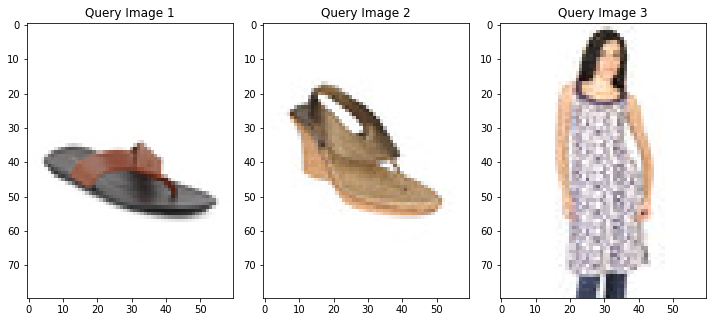

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (10, 10))
for i in range(3):
    ax = axes[i]
    ax.imshow(query_images[i])
    ax.set_title("Query Image %s"%(i + 1))
plt.tight_layout()
plt.show()

In [ ]:
for img in range(3):
    print("\nText Results for Image {}: \n".format(img + 1))
    for n in range(5):
        print("Text: {:>30} \t Distance: {}".format(text_space[preds[img, n]], distances[img, n]))

        


Text Results for Image 1: 

Text: Men Footwear Sandal Casual Tan Sandals 	 Distance: 0.6701509769978873
Text:              men casual shorts 	 Distance: 1.1531737080515534
Text:                women brown bag 	 Distance: 1.2117380085890754
Text: Women Footwear Shoes Casual Gold Flats 	 Distance: 1.25376717444439
Text:         men casual blue tshirt 	 Distance: 1.26766490212664

Text Results for Image 2: 

Text: Women Footwear Shoes Casual Gold Flats 	 Distance: 0.6107287301647168
Text:                women brown bag 	 Distance: 1.1026048834070754
Text: Men Footwear Sandal Casual Tan Sandals 	 Distance: 1.1881805701376333
Text:                          women 	 Distance: 1.2554198692251908
Text:                          brown 	 Distance: 1.283344371168427

Text Results for Image 3: 

Text: Women Apparel Topwear Ethnic White Kurtas 	 Distance: 0.5444920883791311
Text:       women black casual shirt 	 Distance: 1.3801908898080624
Text:                women brown bag 	 Distance: 1.44654863

Before carrying on any further experiments we will attempt to create a metric in order to evaluate the performance of our model. From here we can tune the Nearest Neighbour model to only receive the labels that are most related to the image

Here is a general breakdown of how I plan to pivot the direction of the current experiement I am carrying out.



*   Now the text space will consist of the full captions and we will implement a simply accuracy metric to determine whether the first predicted caption from the space is the correct caption
*   Then we will attempt to tune the model so that we depend on only the distance metric to retrieve the most important labels
*   Then we will train the model by splitting the captions into short labels and creating sets of positive captions for each image much like in the Tractable problem, and observe whether the correct labels are retrieved based on the distance metric from the NN
*   Come up with a sensible metric to (potentially some multilabel classification metric) evaluate the label retrieval of the model





# Recall @ K Experiments

In [81]:
text_space = [captions[i] for i in test_idx]

cleaned_text = remove_punctuation(text_space)
query_tokens = tokenizer(cleaned_text)
pad_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

text_encodings = t_model.predict(np.asarray(pad_tokens), verbose = 2)

275/275 - 1s


In [82]:
from tqdm import tqdm

target_image_encoding = []

for img in tqdm(chunker(test_imgs, 128), total=len(test_imgs)//128):
    image_vecs = np.asarray([preprocess_input(img[i]) for i in range(len(img))])
    e = i_model.predict(image_vecs)
    target_image_encoding += e.tolist()

69it [00:14,  4.90it/s]


In [83]:
len(target_image_encoding) == len(text_encodings)

True

In [84]:
from sklearn.neighbors import NearestNeighbors

nn_text = NearestNeighbors(n_jobs=-1, n_neighbors=10)
nn_text.fit(text_encodings)

preds = nn_text.kneighbors(target_image_encoding, return_distance=False)

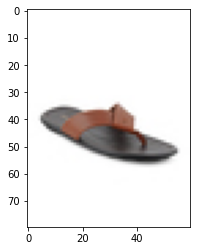

In [85]:
plt.imshow(test_imgs[0])

In [89]:
top_preds = preds[:, :10]
score = 0
for i in range(len(preds)):
    if text_space[i] in np.asarray(text_space)[top_preds[i]]:
        score += 1
score / len(preds)

0.5319390770629688

# Experiment 1

Encode all the captions in the test set and fit the Nearest Neighbour algorithm on all the text encodings. Then we encode all the images and for each image we get retrieve the nearest neighbour text encoding and check that the retrieved caption is the same as the original ground truth

In [ ]:
#We will use the following metric to evalutate performance

def accuracy_(y_true, y_pred):
    score = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            score += 1
    acc_score = score / len(y_true)
    return acc_score


In [ ]:
def recall_at_k((y_true, y_pred):
    top_preds = y_pred[:, :k]
    score = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            score += 1
    acc_score = score / len(y_true)
    return acc_score)

In [ ]:
text_space = [captions[i] for i in test_idx]

cleaned_text = remove_punctuation(text_space)
query_tokens = tokenizer(cleaned_text)
pad_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

text_encodings = t_model.predict(np.asarray(pad_tokens), verbose = 2)

275/275 - 1s


In [ ]:
target_image_encoding = []

image_vecs = np.asarray([preprocess_input(test_imgs[i]) for i in range(len(test_imgs))])
e = i_model.predict(image_vecs)
target_image_encoding += e.tolist()

In [ ]:
nn_text = NearestNeighbors(n_jobs=-1, n_neighbors=1)
nn_text.fit(text_encodings)

distances, preds = nn_text.kneighbors(target_image_encoding, return_distance=True)

In [ ]:
preds_reshape = np.reshape(preds, (8798,))

In [ ]:
preds_reshape[0]

4643

In [ ]:
accuracy_(list(range(len(text_space))), preds_reshape)

0.0347806319618095

In [ ]:
acc_score = accuracy_(text_space, np.asarray(text_space)[preds_reshape])

print("Overall Accuracy is {}".format(acc_score))

Overall Accuracy is 0.35110252330075015


Conclusion: Sending all the captions to the NN model is not sensible. In our problem setting each image only gets a label subset of all the parts in the car so we should change this

# Experiement 2

Now we will batch the test data into batches of 10. All captions from each batch are fit on the NN model and then each image attempts to retrieve the nearest neighbour. 

NOTE: This still does not appropriately fit our problem setting as we are simply retrieving the nearest neighbour as oppose to retrieving multiple labels that the model confidently believes to relate to the image.

In [ ]:
grouped_ids = chunker(test_idx, 10)

In [ ]:
img_ids = []
acc_scores = []
for groups in grouped_ids:
    text_space = [captions[i] for i in groups]

    cleaned_text = remove_punctuation(text_space)
    query_tokens = tokenizer(cleaned_text)
    pad_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

    text_encodings = t_model.predict(np.asarray(pad_tokens), verbose = 2)

    target_image_encoding = []

    image_vecs = np.asarray([preprocess_input(ordered_imgs[i]) for i in groups])
    e = i_model.predict(image_vecs)
    target_image_encoding += e.tolist()

    nn_text = NearestNeighbors(n_jobs=-1, n_neighbors=1)
    nn_text.fit(text_encodings)

    preds = nn_text.kneighbors(target_image_encoding, return_distance=False)
    top_preds = preds[:, :1]
    score = 0
    for i in range(len(preds)):
        if text_space[i] in np.asarray(text_space)[top_preds[i]]:
            score += 1
    acc = score / len(preds)
    #pred_text = np.asarray(text_space)[preds_reshape]
    #acc = accuracy_(text_space, pred_text)
    acc_scores.append(acc)
    clear_output(True)

print("Average Accuracy over each set of 10 labels: {}".format(sum(acc_scores)/len(acc_scores)))

Average Accuracy over each set of 10 labels: 0.9489772727272677


In [ ]:
grouped_ids = chunker(test_idx, 20)

In [ ]:
img_ids = []
acc_scores = []
for groups in grouped_ids:
    text_space = [captions[i] for i in groups]

    cleaned_text = remove_punctuation(text_space)
    query_tokens = tokenizer(cleaned_text)
    pad_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

    text_encodings = t_model.predict(np.asarray(pad_tokens), verbose = 2)

    target_image_encoding = []

    image_vecs = np.asarray([preprocess_input(ordered_imgs[i]) for i in groups])
    e = i_model.predict(image_vecs)
    target_image_encoding += e.tolist()

    nn_text = NearestNeighbors(n_jobs=-1, n_neighbors=1)
    nn_text.fit(text_encodings)

    preds = nn_text.kneighbors(target_image_encoding, return_distance=False)
    preds_reshape = np.reshape(preds, (len(groups),))
    pred_text = np.asarray(text_space)[preds_reshape]
    acc = accuracy_(text_space, pred_text)
    acc_scores.append(acc)
    clear_output(True)


print("Average Accuracy over each set of 20 labels: {}".format(sum(acc_scores)/len(acc_scores)))

Average Accuracy over each set of 20 labels: 0.8668813131313129


It is clear in this experiment by considering a small subset of labels for each image, the model is able to accurately retrieve the caption that best describes the image.

# Experiment 3

In this experiment we will train the model differently to how it was trained before. As oppose to combining each feature of the image to create a single caption, we are going to feed the model the image and a randomly selected feature on each epoch.


Check in seperate notebook

# Experiment 4

We are going to consider a single category of labels in order to divert this problem towards the binary classification problem setting.

In [ ]:
# We will consider the masterCategory for the purpose of this task

master_cat = [caption_labels[i][1] for i in test_idx]

# We will create a ground truth binary variable for all images of each label
label_ground_truths = []
for label in list(set(master_cat)):
    ground_truths = [1 if master_cat[i] == label else 0 for i in range(len(master_cat))]
    label_ground_truths.append(ground_truths)

In [ ]:
text_space = list(set(master_cat))

cleaned_text = remove_punctuation(text_space)
query_tokens = tokenizer(cleaned_text)
pad_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

text_encodings = t_model.predict(np.asarray(pad_tokens), verbose = 2)

nn_text = NearestNeighbors(n_jobs=-1, n_neighbors=len(text_space))
nn_text.fit(text_encodings)

1/1 - 0s


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=6, p=2, radius=1.0)

In [ ]:
target_image_encoding = []

for img in tqdm(chunker(test_imgs, 128), total=len(test_imgs)//128):
    image_vecs = np.asarray([preprocess_input(img[i]) for i in range(len(img))])
    e = i_model.predict(image_vecs)
    target_image_encoding += e.tolist()

distances, preds = nn_text.kneighbors(target_image_encoding, return_distance = True)

69it [00:05, 12.59it/s]                        


In [ ]:
all_label_distances = np.zeros_like(distances)

for i, (dist, pred) in enumerate(zip(distances, preds)):
    label_distances = [x for y, x in sorted(zip(pred, dist))]
    all_label_distances[i] = label_distances

In [ ]:
label_dict = [{'Ground Truths' : label_ground_truths[i],
               'Distances' : all_label_distances.T[i]} for i in range(len(text_space))]

In [ ]:
for i in range(len(label_dict)):
    df = pd.DataFrame(label_dict[i])
    print("{}\n\n{}\n".format(text_space[i], df))

Apparel

      Ground Truths  Distances
0                 0   1.528504
1                 1   1.279137
2                 0   1.635324
3                 0   1.588565
4                 1   1.408966
...             ...        ...
8793              0   1.497911
8794              0   1.545411
8795              0   1.487340
8796              0   1.502688
8797              0   1.505473

[8798 rows x 2 columns]

Accessories

      Ground Truths  Distances
0                 0   1.477341
1                 0   1.615535
2                 1   1.286870
3                 1   1.405327
4                 0   1.433425
...             ...        ...
8793              1   1.386067
8794              1   1.378718
8795              1   1.358560
8796              1   1.415409
8797              1   1.039141

[8798 rows x 2 columns]

Personal Care

      Ground Truths  Distances
0                 0   1.191108
1                 0   1.329373
2                 0   1.395316
3                 0   1.225161
4           

In [ ]:
from scipy.special import softmax

reg_inverse_distances = np.zeros_like(all_label_distances)
for i, arr in enumerate(all_label_distances):
    inv_dist = 1 / arr
    reg_inverse_distances[i] = softmax(inv_dist)

In [ ]:
len(label_dict)

6

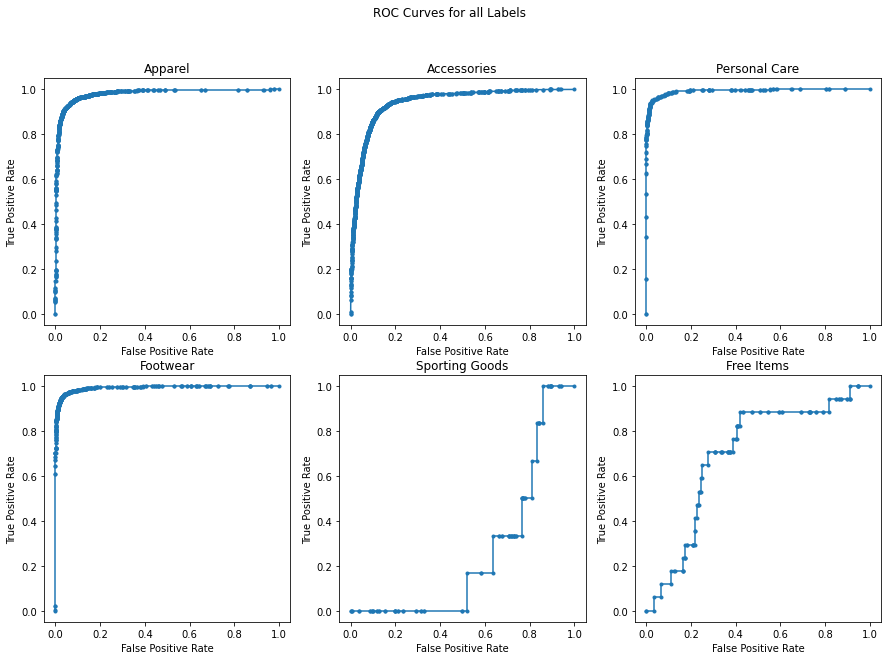

In [ ]:
from sklearn.metrics import roc_curve
# We will compute the ROC curve on Footwear

fig, axs = plt.subplots(2, 3, figsize = (15, 10))

fig.suptitle("ROC Curves for all Labels")

for idx in range(len(label_dict)):

    i = idx // 3  # Get subplot row
    j = idx % 3  # Get subplot column

    ax = axs[i, j]

    fpr, tpr, _ = roc_curve(label_ground_truths[idx], reg_inverse_distances.T[idx])

    ax.set_title(text_space[idx])
    ax.plot(fpr, tpr, marker = '.')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

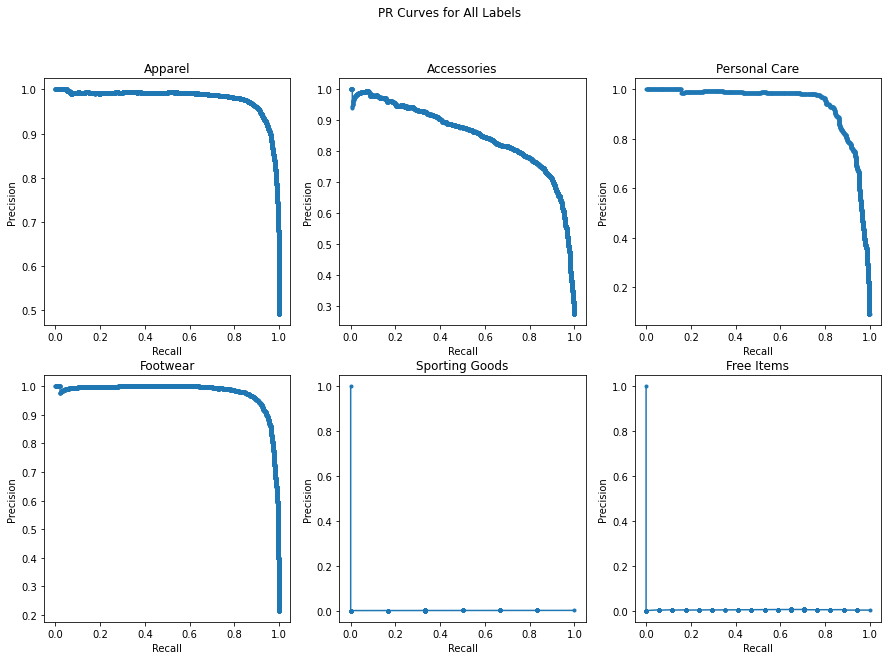

In [ ]:
from sklearn.metrics import precision_recall_curve
fig, axs = plt.subplots(2, 3, figsize = (15, 10))

fig.suptitle("PR Curves for All Labels")

for idx in range(len(label_dict)):

    i = idx // 3  # Get subplot row
    j = idx % 3  # Get subplot column

    ax = axs[i, j]

    precision, recall, _ = precision_recall_curve(label_ground_truths[idx], reg_inverse_distances.T[idx])

    ax.set_title(text_space[idx])
    ax.plot(recall, precision, marker = '.')
    ax.set(xlabel='Recall', ylabel='Precision')

In [ ]:
from sklearn.metrics import roc_auc_score

for idx in range(len(text_space)):
    score = roc_auc_score(label_ground_truths[idx], reg_inverse_distances.T[idx])
    print("Label {} has a ROC-AUC score of {}".format(text_space[idx], score))

Label Apparel has a ROC-AUC score of 0.9820445021519009
Label Accessories has a ROC-AUC score of 0.9439173247538266
Label Personal Care has a ROC-AUC score of 0.9926712759530961
Label Footwear has a ROC-AUC score of 0.9919545804617182
Label Sporting Goods has a ROC-AUC score of 0.26311798604792236
Label Free Items has a ROC-AUC score of 0.6960817808503654
